<img src="https://raw.githubusercontent.com/raimundo1994/logos/main/logo_gravmag.png" alt="logo" style="max-width: 450px;display: block">

<h1 style="text-align: center; font-size: 3rem;">Processamento e interpretação de
dados de campos potenciais  </h1>

<h1 style="text-align: center; font-size: 2.0rem;">Anomalia de Campo Total (Total-Field Anomaly -TFA)</h1>

## ℹ️ Sobre este tutorial

***Este Jupyter notebook ilustra como calcular os componentes do campo magnético e a TFA (Total Field Anomaly), produzidos por prismas retangulares homogêneos. O campo magnético e a TFA são grandezas importantes na área da geofísica e são utilizados para entender as propriedades magnéticas de diferentes formações geológicas***.

<img src="figuras/tfa.png" style="max-width: 550px">

## 🐍 Importe as bibliotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv # pacote de plotagem 3D

In [2]:
from codes import functions as func
from codes import plot_functions as plf
from codes import plot_function_pyvista as plv
from codes import prism

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

### Grid de pontos onde é calculadao o dado sintético

In [4]:
# numero de pontos ao longo de x e y 
shape = (50, 50)

# Oeste, Leste, Sul, Norte
area = [-5000, 5000, -5000, 6000]

# Coordenadas no sistema topocentrico 
y = np.linspace(area[0], area[1], shape[0])
x = np.linspace(area[2], area[3], shape[1])
y, x = np.meshgrid(y, x)
y = np.ravel(y)
x = np.ravel(x)
z = np.zeros_like(y) -150

coordinates = np.vstack([y, x, z])

In [5]:
coordinates.shape

(3, 2500)

### Cria modelo formado por prismas

In [6]:
# prismas = [Oeste, Leste, Sul, Norte, Topo, Base]
prismas = np.array([[2000., 3000., -1500., -500.,10.,200.],
                    [1600., 2600., -2500., -1500.,10.,200.], 
                    [-5000., 5000., 1500., 2500.,10.,200.],
                    [-3000., -2000., -4000., 1500.,10.,200.]])

### Magnetização de cada prisma a primeira, segunda e terceira colunas contêm a intensidade de magnetização (em nT), inclinação e declinação (em graus) das fontes simuladas (prismas)

In [7]:
magnetization = np.array([[1.4, 30, -10],
                          [1.3, 30, -10],
                          [1.1, 60, 40],
                          [1.2, -20, -75]])

### Plot 3D do modelo formado por prismas retangulares 

* ***Habilite as linhas abaixo para fazer a plotagem 3D***

### Campo geomagnético principal sintético

In [8]:
# ponto de referencia
yc, xc = 0, 1000

# inclinação (graus)
I0 = 20 + 1e-4*(x-xc) + 3e-4*(y-yc) + 1e-8*(x-xc)*(x-xc) + 1e-8*(y-yc)*(y-yc)

# declinação (graus)
D0 = -43 + 6e-5*(x-xc) + 1e-4*(y-yc) + 3e-9*(x-xc)*(x-xc) + 4e-9*(y-yc)*(y-yc)

# intensidade (nT)
F0 = 23400+ 1e-4*(x-xc) + 1e-4*(y-yc) + 0*(x-xc)*(x-xc) + 0*(y-yc)*(y-yc)

# Componetes cartesianas do campo principal
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

### Plot da inclinação, declinação e intensidade do campo geomagnético principal sintético

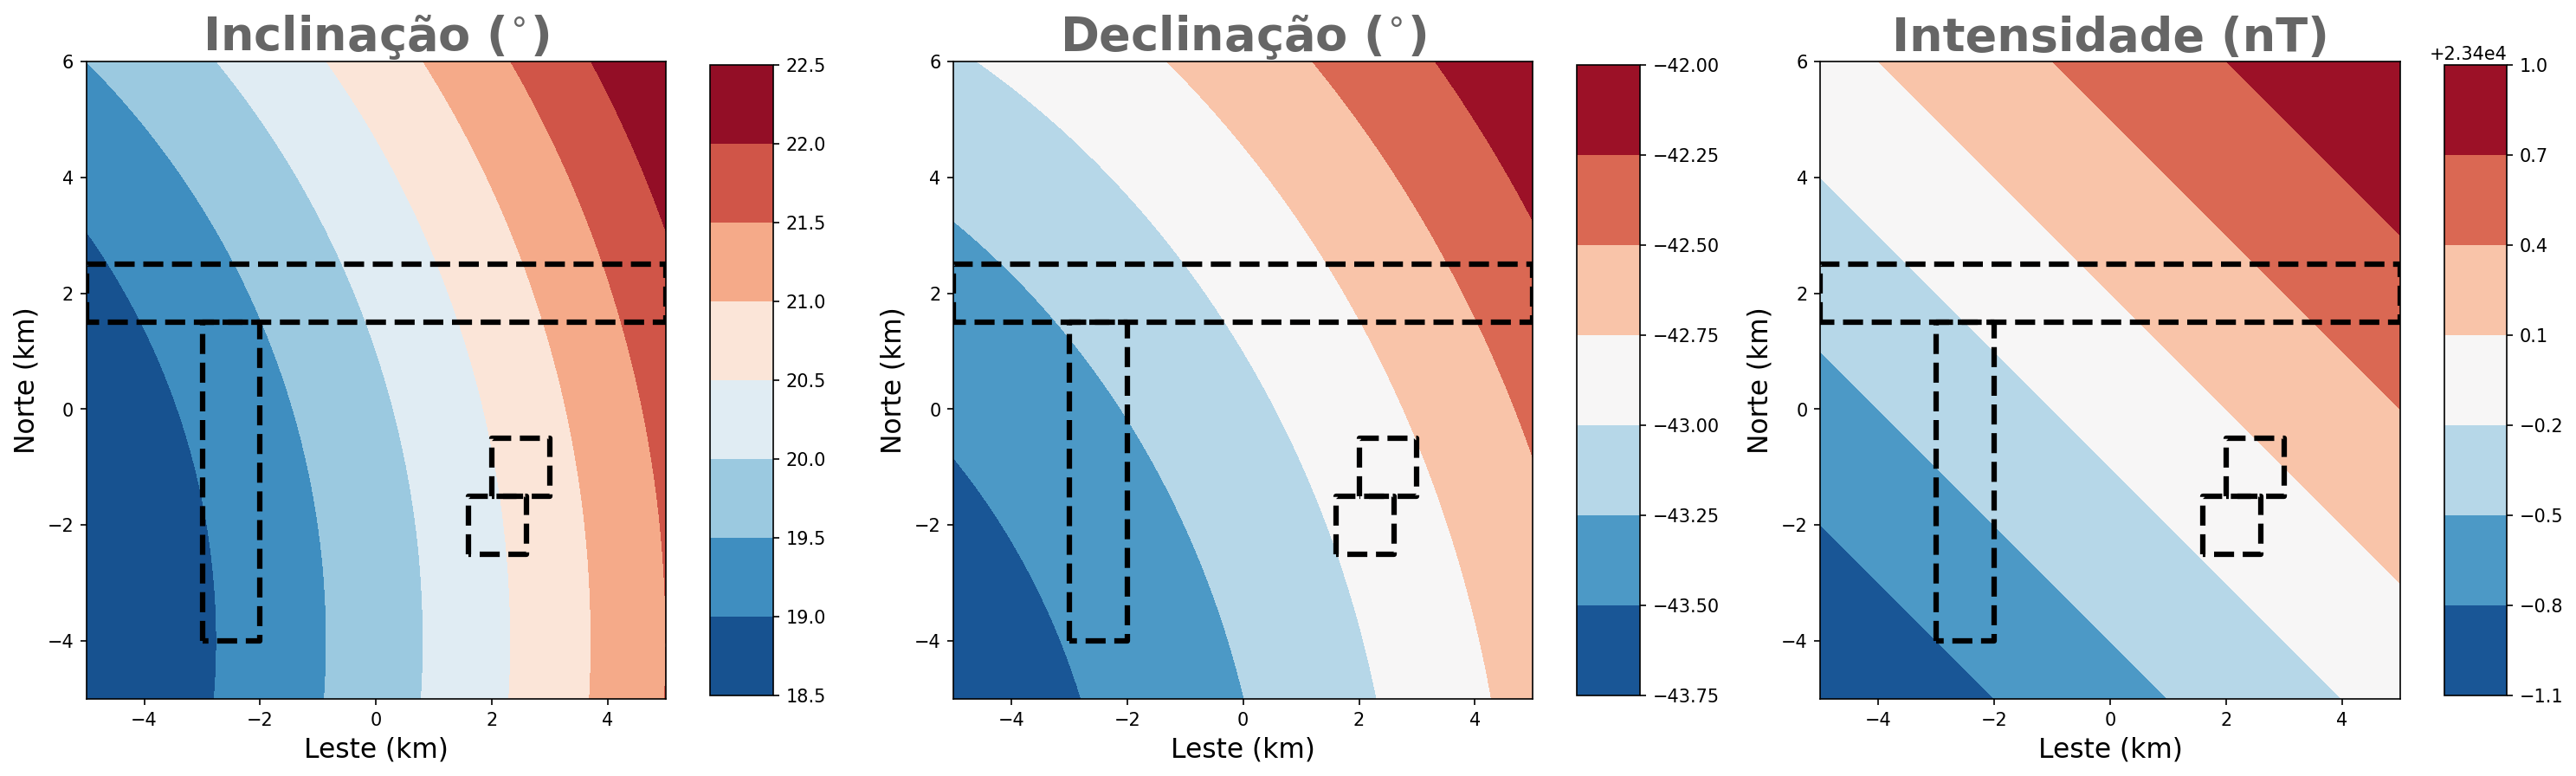

In [9]:
fields = [I0, D0, F0]
windows = [1, 2, 3]
titles = ['Inclinação ($^{\circ}$)', 'Declinação ($^{\circ}$)', 'Intensidade (nT)']

plt.figure(figsize=(20,10))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=26,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar(shrink=0.5, pad=0.06, aspect=10)
    plf.model_boundaries_2(prismas, m2km=True,linewidth = 3)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-1/campo_principal.png',dpi = 500, bbox_inches = 'tight')
plt.show()

### Dados sintéticos

In [10]:
# Calcula as componentes do campo magnético produzido pelas fontes simuladas (prismas)
bx = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_x')
by = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_y')
bz = prism.mag(coordinates=coordinates, prisms=prismas, magnetization=magnetization, field='b_z')

# Add a noise to the synthetic data
bx += np.random.normal(loc=0, scale=5, size=bx.size)
by += np.random.normal(loc=0, scale=5, size=by.size)
bz += np.random.normal(loc=0, scale=5, size=bz.size)

# Calcula a anomalia de compo total (total-field anomaly - TFA)
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Calcula a anomalia de campo total aproximada 
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### Plot das componentes do campo magnético produzidas pelos prismas e TFA

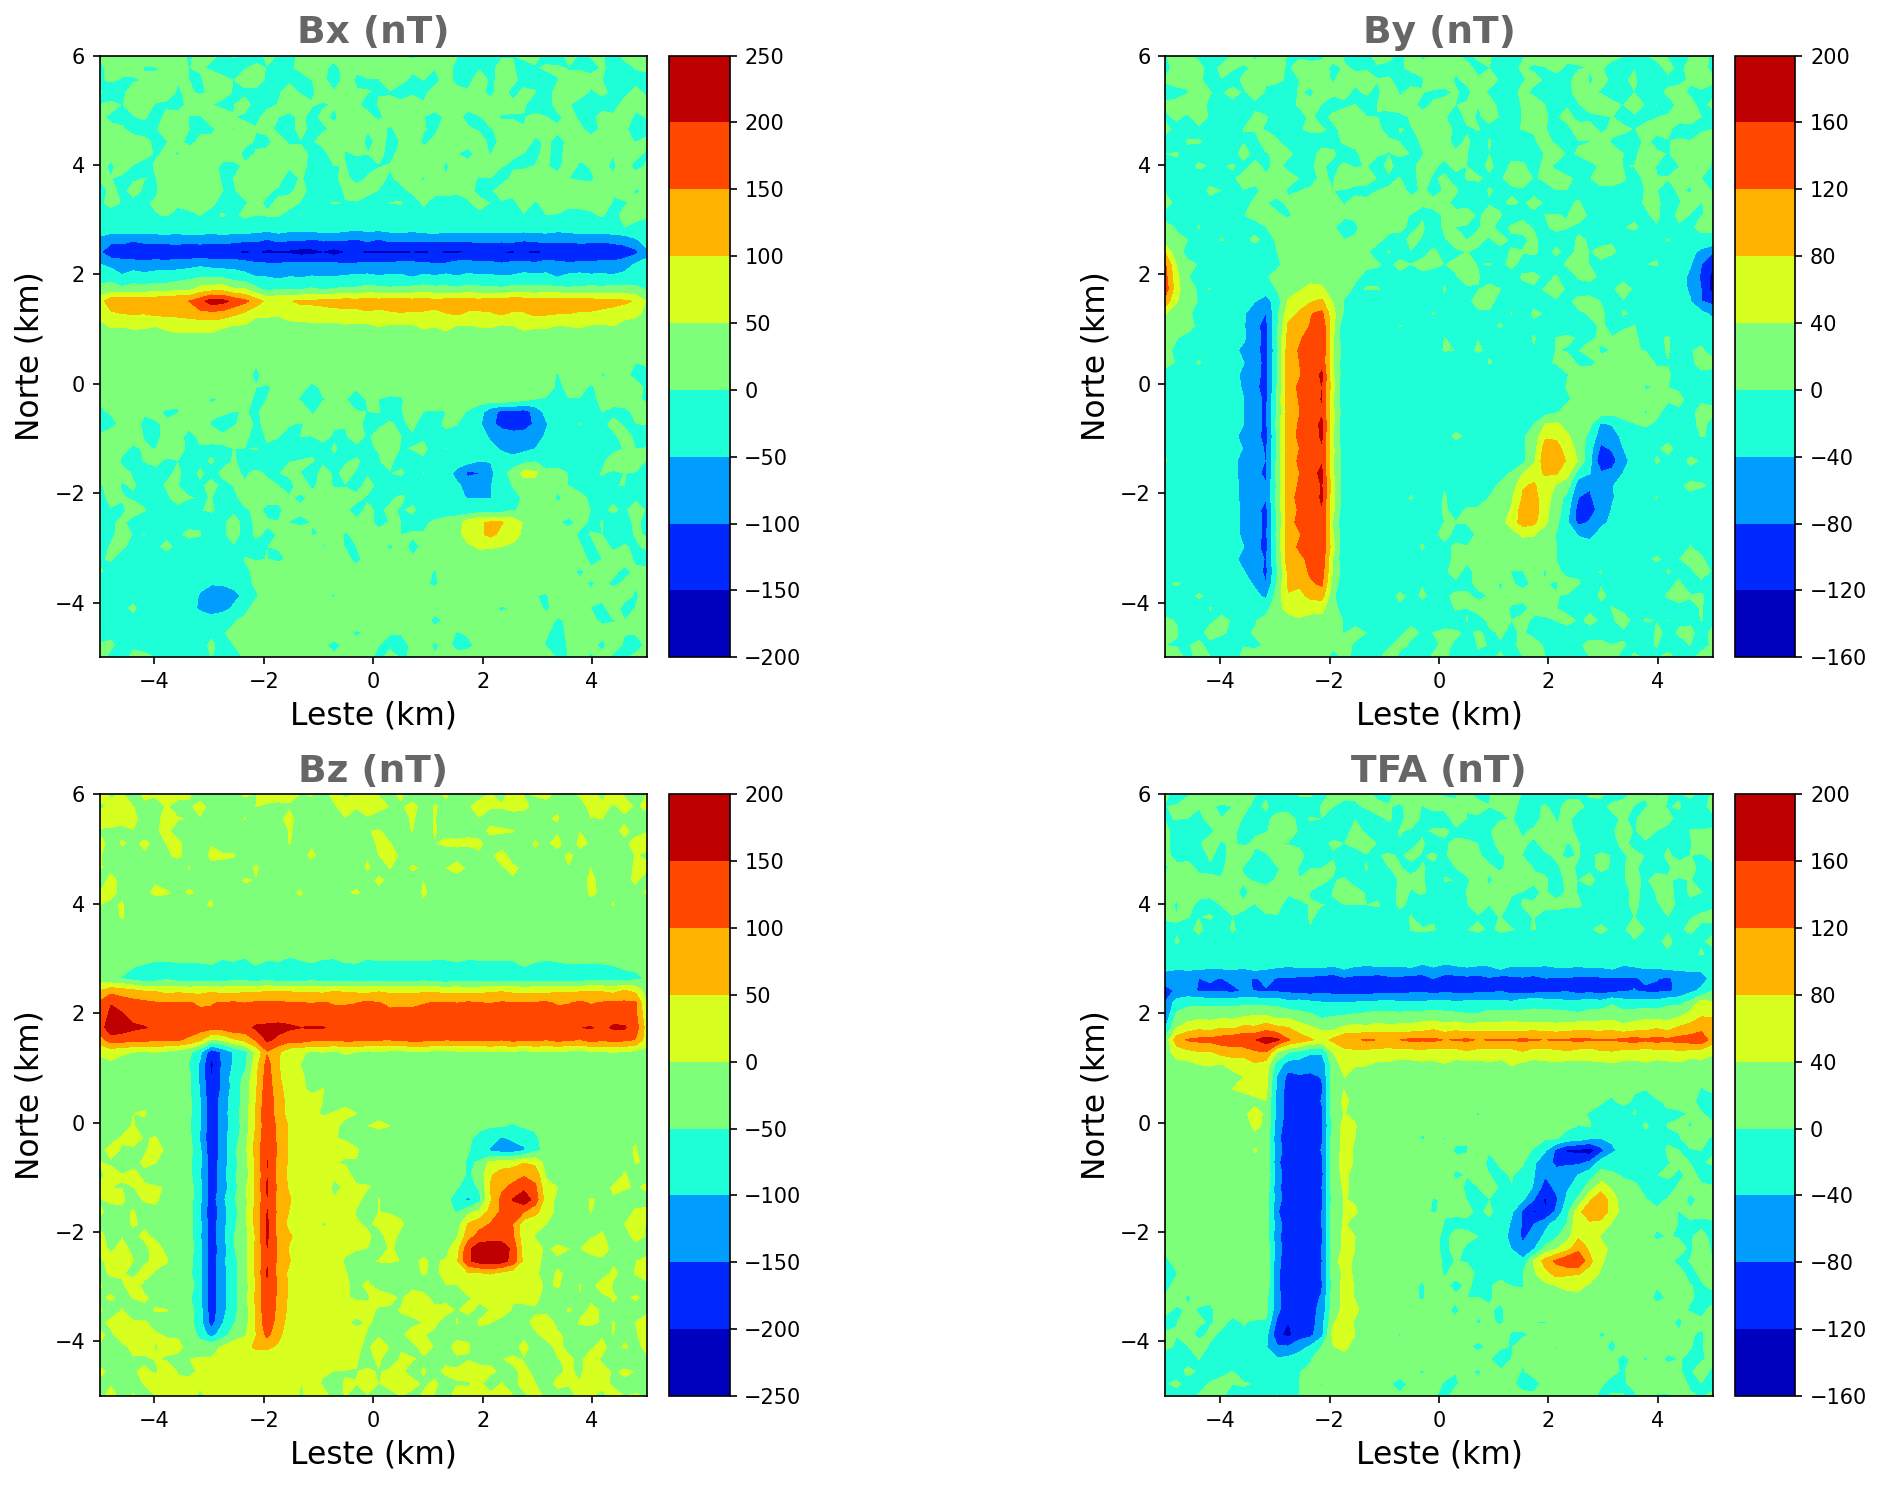

In [11]:
fields = [bx, by, bz, tfa]
windows = [1, 2, 3, 4]
titles = ['Bx (nT)', 'By (nT)', 'Bz (nT)', 'TFA (nT)']

plt.figure(figsize=(15,10))

for w, window in enumerate(windows):

    plt.subplot(2,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    plt.colorbar(shrink=1.0, pad=0.02, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-1/TFA.png',dpi = 500, bbox_inches = 'tight')
plt.show()

### Plot comparando os resultados de TFA e TFA aproximada, mostrando que elas não tem diferença significativa.

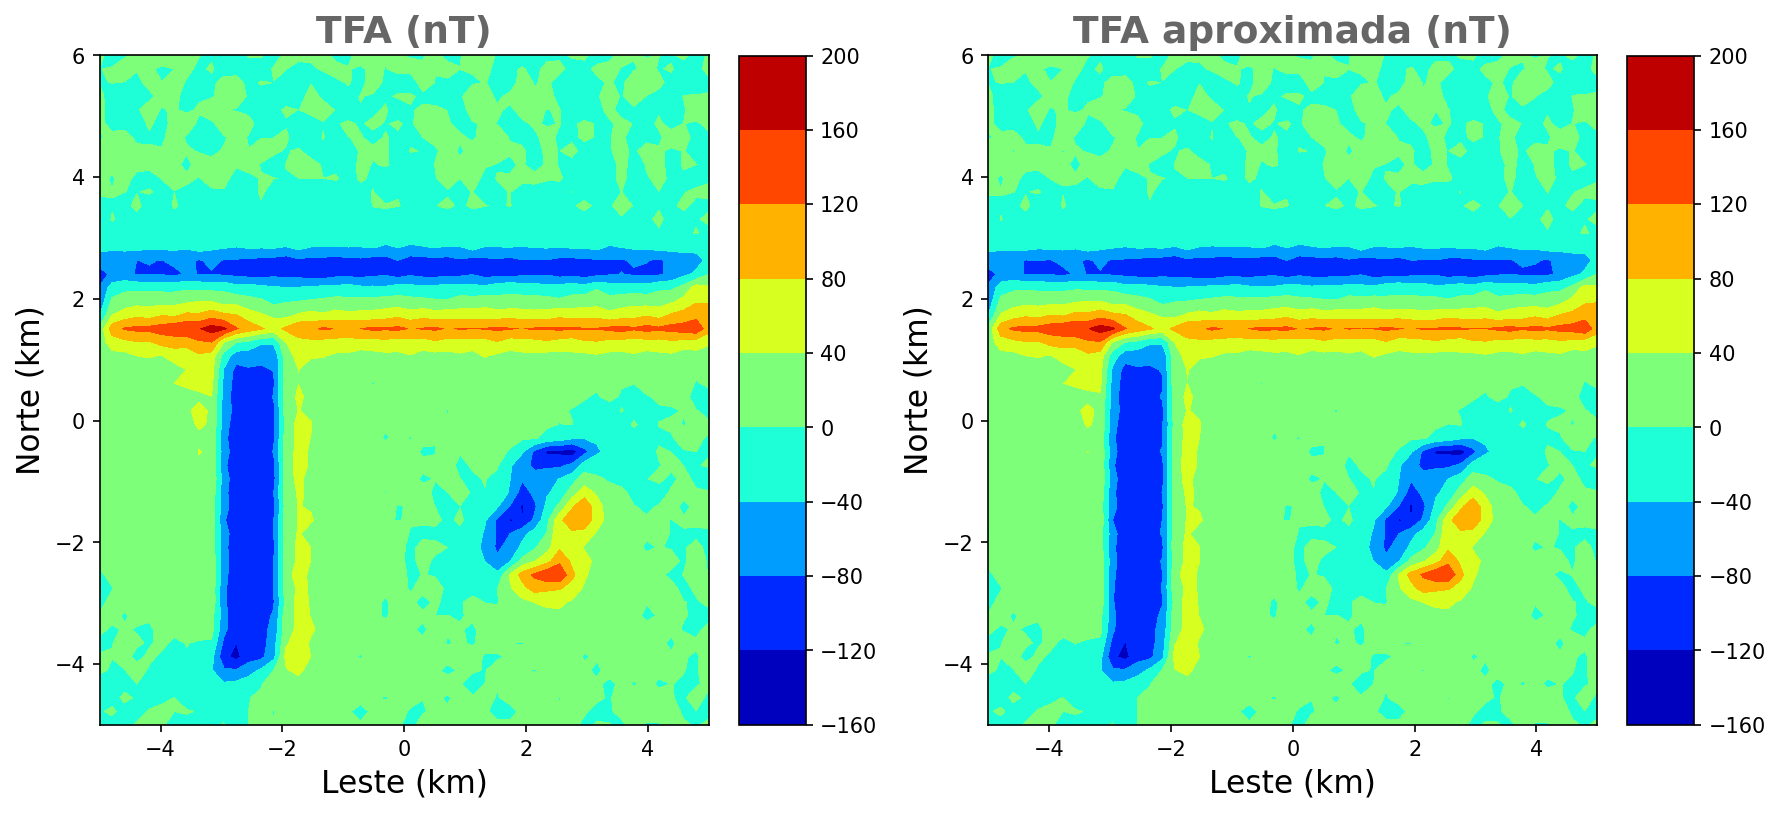

In [12]:
fields = [tfa, approx_tfa]
windows = [1, 2]
titles = ['TFA (nT)', 'TFA aproximada (nT)']

plt.figure(figsize=(12,10))

for w, window in enumerate(windows):

    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=18,weight='bold', alpha=.6)
    plt.axis('scaled')
    plt.contourf(y.reshape(shape)*0.001, 
                 x.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='jet')
    
    plt.colorbar(shrink=0.46, pad=0.04, aspect=10)
#     plf.model_boundaries_2(prismas, m2km=True,linewidth = 2)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('Leste (km)', fontsize=15)
    plt.ylabel('Norte (km)', fontsize=15)

plt.tight_layout()
plt.savefig('figuras/notebook-1/TFA aproximada.png',dpi = 500, bbox_inches = 'tight')
plt.show()